<a href="https://colab.research.google.com/github/AD18/Multi-channel-Filter-bank-using-Systolic-arrays/blob/main/Systollic_Array_FIR_Filter_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIR Bank

## Install Icarus Verilog on Colab

In [1]:
!sudo apt-get update
!sudo apt-get install -y iverilog

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,305 kB]
Get:14 https://r2u.stat

## Input samples and filter co-efficients generator

In [2]:
import numpy as np
from scipy.signal import firwin
import csv

# ===== Adjustable Parameters =====
NUM_FILTERS = 15     # toggle 5 or 125 (or any value)
NUM_TAPS    = 15
NUM_SAMPLES = 100
Fs          = 2000
scale       = 32768
N = NUM_SAMPLES

# Input signal: 4 tones spread across the band
Ts = 1 / Fs
t = np.arange(N) * Ts
x = (np.sin(2*np.pi*100*t) +
     np.sin(2*np.pi*400*t) +
     np.sin(2*np.pi*700*t) +
     np.sin(2*np.pi*1000*t))
x_fixed = np.round(x * scale).astype(np.int32)

# Save input samples in hex for $readmemh
with open("input_samples.mem", "w") as f:
    for val in x_fixed:
        f.write(f"{np.uint32(val):08X}\n")

# Generate filters
filters = []
for i in range(NUM_FILTERS):
    # Spread cutoffs safely across band, stay below Nyquist
    cutoff = 50 + i * ((Fs/2 - 100) / NUM_FILTERS)
    cutoff = min(cutoff, Fs/2 - 1)   # avoid hitting Nyquist exactly
    h = firwin(NUM_TAPS, cutoff=cutoff, fs=Fs, window='hamming')
    h_scaled = np.round(h * scale).astype(np.int32)
    filters.append(h_scaled)

# Save coefficients in mem format
with open("filter_coeffs.mem", "w") as f:
    for filt in filters:
        for val in filt:
            f.write(f"{np.uint32(val):08X}\n")

# Optional CSV for inspection
with open("filter_coeffs.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([f"Tap {i}" for i in range(NUM_TAPS)])
    for filt in filters:
        writer.writerow(filt.tolist())   # ensure proper row format

# Generate Verilog defines header
with open("defines.vh", "w") as f:
    f.write(f"`define NUM_FILTERS {NUM_FILTERS}\n")
    f.write(f"`define NUM_TAPS {NUM_TAPS}\n")
    f.write(f"`define NUM_SAMPLES {NUM_SAMPLES}\n")


## FIR Bank Verilog Codes

In [3]:
# ===== block.v =====
block = [
    "// One MAC \"processing element\" (PE) used in the systolic chain.",
    "// Matches your original behavior: passes west -> east, outputs the product this cycle.",
    "module block(",
    "    input  signed [31:0] inp_north,   // coefficient (tap)",
    "    input  signed [31:0] inp_west,    // sample (streamed)",
    "    input                 clk,",
    "    input                 rst,",
    "    output reg signed [31:0] outp_east,",
    "    output reg signed [63:0] result",
    ");",
    "    wire signed [63:0] multi;",
    "    assign multi = inp_north * inp_west;",
    "",
    "    always @(posedge clk or posedge rst) begin",
    "        if (rst) begin",
    "            outp_east <= 0;",
    "            result    <= 0;",
    "        end else begin",
    "            outp_east <= inp_west;",
    "            result    <= multi;   // product for this cycle (no accumulation here)",
    "        end",
    "    end",
    "endmodule"
]

with open("block.v", "w") as f:
    f.write("\n".join(block))

# ===== systolic_array.v =====
systolic_array = [
    "// One FIR filter of NUM_TAPS using a systolic chain of 'block' PEs.",
    "// coeffs_flat carries NUM_TAPS 32-bit signed coeffs, flattened.",
    "module systolic_array #(",
    "    parameter NUM_TAPS = 5",
    ")(",
    "    input  signed [31:0] inp_west,",
    "    input  signed [32*NUM_TAPS-1:0] coeffs_flat,",
    "    input                 clk,",
    "    input                 rst,",
    "    output reg signed [71:0] y_out",
    ");",
    "    wire [32*NUM_TAPS-1:0] east_bus;",
    "    wire [64*NUM_TAPS-1:0] result_bus;",
    "",
    "    genvar i;",
    "    generate",
    "        for (i = 0; i < NUM_TAPS; i = i + 1) begin : TAP",
    "            wire signed [31:0] coeff_i;",
    "            assign coeff_i = coeffs_flat[(i+1)*32-1 -: 32];",
    "",
    "            if (i == 0) begin : T0",
    "                block PE (",
    "                    .inp_north (coeff_i),",
    "                    .inp_west  (inp_west),",
    "                    .clk       (clk),",
    "                    .rst       (rst),",
    "                    .outp_east (east_bus[(i+1)*32-1 -: 32]),",
    "                    .result    (result_bus[(i+1)*64-1 -: 64])",
    "                );",
    "            end else begin : Tn",
    "                block PE (",
    "                    .inp_north (coeff_i),",
    "                    .inp_west  (east_bus[i*32-1 -: 32]),",
    "                    .clk       (clk),",
    "                    .rst       (rst),",
    "                    .outp_east (east_bus[(i+1)*32-1 -: 32]),",
    "                    .result    (result_bus[(i+1)*64-1 -: 64])",
    "                );",
    "            end",
    "        end",
    "    endgenerate",
    "",
    "    integer k;",
    "    reg signed [71:0] sum;",
    "    always @* begin",
    "        sum = 0;",
    "        for (k = 0; k < NUM_TAPS; k = k + 1) begin",
    "            sum = sum + {{8{result_bus[(k+1)*64-1]}}, result_bus[(k+1)*64-1 -: 64]};",
    "        end",
    "    end",
    "",
    "    always @(posedge clk or posedge rst) begin",
    "        if (rst) begin",
    "            y_out <= 0;",
    "        end else begin",
    "            y_out <= sum;",
    "        end",
    "    end",
    "endmodule"
]

with open("systolic_array.v", "w") as f:
    f.write("\n".join(systolic_array))

# ===== topmodule.v =====
topmodule = [
    "// Instantiates NUM_FILTERS parallel FIR filters.",
    "// coeffs_flat_bus contains NUM_FILTERS * NUM_TAPS signed 32-bit coeffs (flattened).",
    "// Outputs are flattened as NUM_FILTERS signed 72-bit values.",
    "module topmodule #(",
    "    parameter NUM_FILTERS = 5,",
    "    parameter NUM_TAPS    = 5",
    ")(",
    "    input                 clk,",
    "    input                 rst,",
    "    input  signed [31:0]  inp_west,",
    "    input  signed [32*NUM_FILTERS*NUM_TAPS-1:0] coeffs_flat_bus,",
    "    output signed [72*NUM_FILTERS-1:0]          y_out_flat",
    ");",
    "    genvar f;",
    "    generate",
    "        for (f = 0; f < NUM_FILTERS; f = f + 1) begin : FILT",
    "            wire signed [32*NUM_TAPS-1:0] coeffs_this_filter;",
    "            assign coeffs_this_filter =",
    "                coeffs_flat_bus[(f+1)*NUM_TAPS*32-1 -: (NUM_TAPS*32)];",
    "",
    "            wire signed [71:0] y_this;",
    "",
    "            systolic_array #(.NUM_TAPS(NUM_TAPS)) SA (",
    "                .inp_west    (inp_west),",
    "                .coeffs_flat (coeffs_this_filter),",
    "                .clk         (clk),",
    "                .rst         (rst),",
    "                .y_out       (y_this)",
    "            );",
    "",
    "            assign y_out_flat[(f+1)*72-1 -: 72] = y_this;",
    "        end",
    "    endgenerate",
    "endmodule"
]

with open("topmodule.v", "w") as f:
    f.write("\n".join(topmodule))

# ===== testbench.v =====
testbench = [
    "`include \"defines.vh\"",
    "`timescale 1ns/1ps",

    "",
    "module testbench;",
    "    parameter NUM_FILTERS = `NUM_FILTERS;",
    "    parameter NUM_TAPS    = `NUM_TAPS;",
    "    parameter NUM_SAMPLES = `NUM_SAMPLES;",
    "",
    "    reg  clk, rst;",
    "    reg  signed [31:0] inp_west;",
    "    reg  signed [32*NUM_FILTERS*NUM_TAPS-1:0] coeffs_flat_bus;",
    "    wire signed [72*NUM_FILTERS-1:0] y_out_flat;",
    "",
    "    reg signed [31:0] sample_mem [0:NUM_SAMPLES-1];",
    "    reg signed [31:0] coeff_mem  [0:NUM_FILTERS*NUM_TAPS-1];",
    "",
    "    integer i, f, cycle;",
    "    integer outfile;",
    "    integer TOTAL;",
    "",
    "    topmodule #(",
    "        .NUM_FILTERS(NUM_FILTERS),",
    "        .NUM_TAPS   (NUM_TAPS)",
    "    ) DUT (",
    "        .clk            (clk),",
    "        .rst            (rst),",
    "        .inp_west       (inp_west),",
    "        .coeffs_flat_bus(coeffs_flat_bus),",
    "        .y_out_flat     (y_out_flat)",
    "    );",
    "",
    "    initial clk = 0;",
    "    always #5 clk = ~clk;",
    "",
    "    initial begin",
    "        $readmemh(\"input_samples.mem\", sample_mem);",
    "        $readmemh(\"filter_coeffs.mem\", coeff_mem);",
    "",
    "        for (i = 0; i < NUM_FILTERS*NUM_TAPS; i = i + 1)",
    "            coeffs_flat_bus[(i+1)*32-1 -: 32] = coeff_mem[i];",
    "",
    "        outfile = $fopen(\"output.txt\", \"w\");",
    "        if (outfile == 0) begin",
    "            $display(\"ERROR: Could not open output.txt\");",
    "            $finish;",
    "        end",
    "",
    "        rst = 1;",
    "        inp_west = 0;",
    "        repeat (3) @(posedge clk);",
    "        rst = 0;",
    "",
    "        TOTAL = NUM_SAMPLES + NUM_TAPS - 1;",
    "",
    "        for (cycle = 0; cycle <= TOTAL; cycle = cycle + 1) begin",
    "            if (cycle < NUM_SAMPLES)",
    "                inp_west = sample_mem[cycle];",
    "            else",
    "                inp_west = 0;",
    "",
    "            @(posedge clk);",
    "",
    "            if (cycle > 0) begin",
    "                for (f = 0; f < NUM_FILTERS; f = f + 1) begin",
    "                    $fwrite(outfile, \"%0d\", $signed(y_out_flat[(f+1)*72-1 -: 72]));",
    "                    if (f < NUM_FILTERS-1)",
    "                        $fwrite(outfile, \" \");",
    "                end",
    "                $fwrite(outfile, \"\\n\");",
    "            end",
    "        end",
    "",
    "        // close only once, after all writes",
    "        $fclose(outfile);",
    "        $display(\"Wrote %0d rows to output.txt (cycles 1..%0d)\", TOTAL, TOTAL);",
    "        $finish;",
    "    end",
    "",
    "    initial begin",
    "        $dumpfile(\"wave.vcd\");",
    "        $dumpvars(0, testbench);",
    "    end",
    "endmodule"
]

with open("testbench.v", "w") as f:
    f.write("\n".join(testbench))


In [4]:
!iverilog -o testbench.vvp block.v systolic_array.v topmodule.v testbench.v
!vvp testbench.vvp

VCD info: dumpfile wave.vcd opened for output.
Wrote 114 rows to output.txt (cycles 1..114)


## Simulator

Loaded: 100 input samples, (15, 15) coeffs array, (114, 15) output matrix


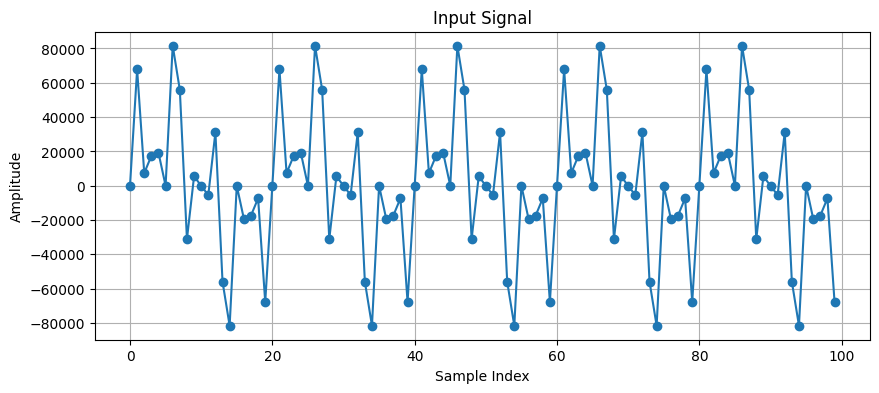


Use the sliders below to toggle between filter groups:


interactive(children=(IntSlider(value=0, description='start_index', max=10, step=5), Output()), _dom_classes=(…

interactive(children=(IntSlider(value=0, description='start_index', max=10, step=5), Output()), _dom_classes=(…

interactive(children=(IntSlider(value=0, description='start_index', max=10, step=5), Output()), _dom_classes=(…

In [5]:
# === 1. Setup ===
import numpy as np
import matplotlib.pyplot as plt
import re
from ipywidgets import interact, IntSlider

# ==== Helper: hex → signed int ====
def hex_to_signed(val, bits=32):
    x = int(val, 16)
    if x & (1 << (bits - 1)):
        x -= 1 << bits
    return x

# ==== Load Verilog defines.vh ====
defines = {}
with open("defines.vh") as f:
    for line in f:
        m = re.match(r'`define\s+(\w+)\s+(\d+)', line)
        if m:
            defines[m.group(1)] = int(m.group(2))

num_filters = defines["NUM_FILTERS"]
num_taps    = defines["NUM_TAPS"]
num_samples = defines.get("NUM_SAMPLES", None)  # optional, only if you need it

# Build output filename pattern same as testbench
output_file = f"output.txt"

# === 2. Load Files ===
input_file = "input_samples.mem"
coeff_file = "filter_coeffs.mem"

# Inputs
with open(input_file) as f:
    inputs = np.array([hex_to_signed(line.strip(), 32) for line in f if line.strip()], dtype=np.int64)

# Coeffs
with open(coeff_file) as f:
    coeffs = np.array([hex_to_signed(line.strip(), 32) for line in f if line.strip()], dtype=np.int64)
coeffs = coeffs.reshape(num_filters, num_taps)

# Outputs
with open(output_file) as f:
    outputs = [list(map(int, line.strip().split())) for line in f if line.strip()]
outputs = np.array(outputs, dtype=np.int64)

print("Loaded:", len(inputs), "input samples,", coeffs.shape, "coeffs array,", outputs.shape, "output matrix")

# === 3. Plot Input Waveform ===
plt.figure(figsize=(10,4))
plt.plot(inputs, marker="o")
plt.title("Input Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# === 4a. Interactive Plot: Impulse Responses ===
def plot_coeffs_group(start_index=0):
    plt.figure(figsize=(10,6))
    for i in range(5):
        idx = start_index + i
        if idx < num_filters:
            plt.plot(coeffs[idx], label=f"Filter {idx}")
    plt.title(f"Impulse Responses (Filters {start_index}..{min(start_index+4, num_filters-1)})")
    plt.xlabel("Tap index")
    plt.ylabel("Coefficient value")
    plt.legend()
    plt.grid(True)
    plt.show()

# === 5a. Interactive Plot: Outputs from Verilog ===
def plot_outputs_group(start_index=0):
    plt.figure(figsize=(12,6))
    for i in range(5):
        idx = start_index + i
        if idx < num_filters:
            plt.plot(outputs[:, idx], label=f"Filter {idx}")
    plt.title(f"FIR Bank Outputs (Filters {start_index}..{min(start_index+4, num_filters-1)})")
    plt.xlabel("Time index (cycles)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# === 6a. Interactive Plot: Frequency Responses ===
def plot_freqs_group(start_index=0):
    plt.figure(figsize=(12,6))
    freqs = np.fft.rfftfreq(2048, 1/2000)  # Fs = 2000 Hz
    for i in range(5):
        idx = start_index + i
        if idx < num_filters:
            H = np.fft.rfft(coeffs[idx], 2048)
            plt.plot(freqs, 20*np.log10(np.abs(H)+1e-12), label=f"Filter {idx}")
    plt.title(f"Filter Frequency Responses (Filters {start_index}..{min(start_index+4, num_filters-1)})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Sliders to toggle filter groups ===
step = 5
max_start = (num_filters-1)//step*step

print("\nUse the sliders below to toggle between filter groups:")

interact(plot_coeffs_group, start_index=IntSlider(min=0, max=max_start, step=step, value=0));
interact(plot_outputs_group, start_index=IntSlider(min=0, max=max_start, step=step, value=0));
interact(plot_freqs_group, start_index=IntSlider(min=0, max=max_start, step=step, value=0));


## Output Verifier

Parameters: filters=15, taps=15, samples=100, total=114
Expecting output file: output.txt
Expected shape: (114, 15)
Verilog shape: (114, 15)
Total mismatches: 0 / 1710

Use the slider below to toggle overlay plots by filter group:


interactive(children=(IntSlider(value=0, description='start_index', max=10, step=5), Output()), _dom_classes=(…

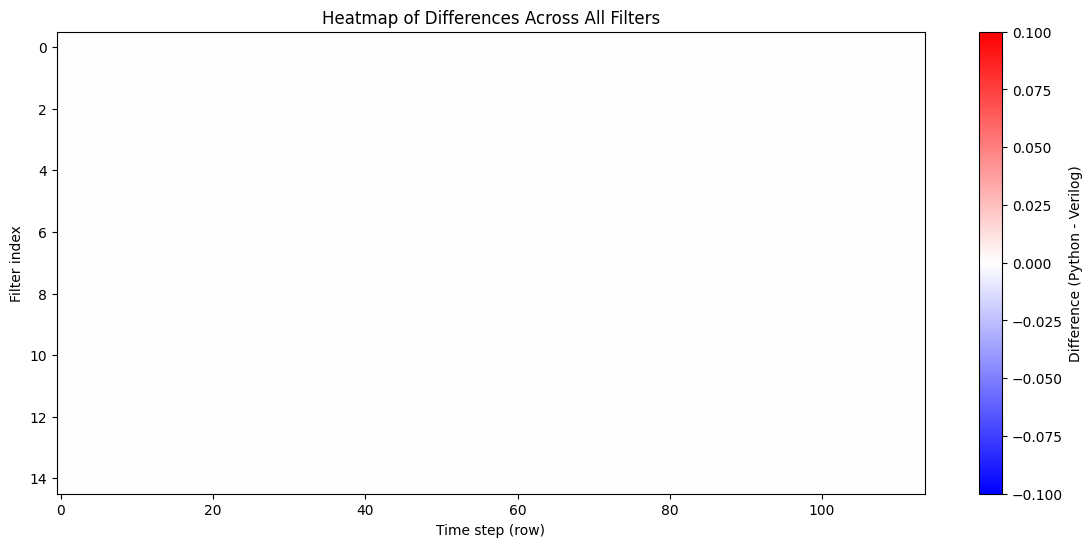

In [8]:
# === 1. Imports ===
import numpy as np
import matplotlib.pyplot as plt
import re
from ipywidgets import interact, IntSlider

# === 2. Load parameters from Verilog defines.vh ===
defines = {}
with open("defines.vh") as f:
    for line in f:
        m = re.match(r'`define\s+(\w+)\s+(\d+)', line)
        if m:
            defines[m.group(1)] = int(m.group(2))

NUM_FILTERS = defines["NUM_FILTERS"]
NUM_TAPS    = defines["NUM_TAPS"]
NUM_SAMPLES = defines["NUM_SAMPLES"]
TOTAL       = NUM_SAMPLES + NUM_TAPS - 1

# Auto-match Verilog’s output filename pattern
output_file = f"output.txt"

print(f"Parameters: filters={NUM_FILTERS}, taps={NUM_TAPS}, samples={NUM_SAMPLES}, total={TOTAL}")
print(f"Expecting output file: {output_file}")

# === 3. Helper: hex string -> signed int32 ===
def hex_to_int32(h):
    v = int(h, 16)
    if v & (1 << 31):
        v -= (1 << 32)
    return v

# === 4. Load input samples ===
with open("input_samples.mem") as f:
    samples = np.array([hex_to_int32(line.strip()) for line in f if line.strip()], dtype=np.int64)

# === 5. Load filter coefficients ===
with open("filter_coeffs.mem") as f:
    coeffs = np.array([hex_to_int32(line.strip()) for line in f if line.strip()], dtype=np.int64)

coeffs = coeffs.reshape(NUM_FILTERS, NUM_TAPS)

# === 6. Compute software FIR bank outputs ===
expected_outputs = []
for filt in coeffs:
    y = np.convolve(samples, filt, mode='full')   # length = NUM_SAMPLES + NUM_TAPS - 1
    expected_outputs.append(y)

expected_outputs = np.stack(expected_outputs, axis=1)  # shape: (TOTAL, NUM_FILTERS)

# === 7. Load Verilog outputs ===
verilog_outputs = np.loadtxt(output_file, dtype=np.int64)

print("Expected shape:", expected_outputs.shape)
print("Verilog shape:", verilog_outputs.shape)

# === 8. Compare all outputs ===
diff = expected_outputs - verilog_outputs
num_mismatches = np.count_nonzero(diff)

print(f"Total mismatches: {num_mismatches} / {expected_outputs.size}")

if num_mismatches > 0:
    r, c = np.argwhere(diff != 0)[0]
    print(f"Example mismatch at row {r}, filter {c}: "
          f"Expected {expected_outputs[r,c]}, Verilog {verilog_outputs[r,c]}")

# === 9. Interactive Overlay Plots ===
def plot_overlay_group(start_index=0):
    plt.figure(figsize=(12,6))
    for i in range(5):
        idx = start_index + i
        if idx < NUM_FILTERS:
            plt.plot(expected_outputs[:,idx], label=f"Python Filter {idx}")
            plt.plot(verilog_outputs[:,idx], '--', label=f"Verilog Filter {idx}")
    plt.legend()
    plt.title(f"Overlay: Python vs Verilog Outputs (Filters {start_index}..{min(start_index+4, NUM_FILTERS-1)})")
    plt.xlabel("Time step (row)")
    plt.ylabel("Output value")
    plt.grid(True)
    plt.show()

step = 5
max_start = (NUM_FILTERS-1)//step*step
print("\nUse the slider below to toggle overlay plots by filter group:")
interact(plot_overlay_group, start_index=IntSlider(min=0, max=max_start, step=step, value=0))

# === 10. Heatmap of differences (all filters at once) ===
plt.figure(figsize=(14,6))
plt.imshow(diff.T, aspect='auto', cmap='bwr', interpolation='nearest')
plt.colorbar(label='Difference (Python - Verilog)')
plt.xlabel("Time step (row)")
plt.ylabel("Filter index")
plt.title("Heatmap of Differences Across All Filters")
plt.show()


## RTL-to-Gate Synthesis Using Yosys

In [7]:
# Install the open-source synthesis tool, Yosys
!sudo apt-get update
!sudo apt-get install -y yosys
# 1. Download a generic standard cell library for technology mapping.
# We'll use the Nangate 45nm Open Cell Library as an example.
!wget https://raw.githubusercontent.com/The-OpenROAD-Project/OpenROAD-flow-scripts/master/flow/platforms/nangate45/lib/NangateOpenCellLibrary_typical.lib -O nangate45.lib

# 2. Run the Yosys synthesis tool.
# The '-p' flag lets us pass a sequence of commands.
#   - read_verilog: Loads your design files.
#   - synth -top: Performs the main synthesis process on the specified top module.
#   - dfflibmap & abc: Maps the synthesized logic to the cells in the .lib file.
#   - write_verilog: Outputs the final gate-level netlist.
!yosys -p ' \
    read_verilog topmodule.v systolic_array.v block.v; \
    synth -top topmodule; \
    dfflibmap -liberty nangate45.lib; \
    abc -liberty nangate45.lib; \
    write_verilog -noattr synthesized_netlist.v \
'

# 3. (Optional) Display the first 50 lines of the resulting netlist.
!echo "--- Synthesis Complete ---"
!echo "Displaying the first 50 lines of synthesized_netlist.v:"
!head -n 50 synthesized_netlist.v

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag